In [14]:
# =============================
# STEP 1 - IMPORT ALL LIBRARIES
# =============================
!pip install catboost
!pip install pycountry
#!pip install ydata-profiling
#from ydata_profiling import ProfileReport
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from functools import reduce
from sklearn.decomposition import FactorAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
# =============================
# STEP 2 - PROCESS INPUT DATA
# =============================

# CO2 data
co2_df = pd.read_csv(r"/content/annual-co2-emissions-per-country.csv", encoding="cp1252")
# Fix the encoding issue in the column name
co2_df.rename(
    columns={
        'Entity': 'Country',
        'Annual COâ‚‚ emissions': 'Annual CO₂ emissions'
    },
    inplace=True
)
co2_pivot = co2_df.pivot(index='Country', columns='Year', values='Annual CO₂ emissions')
co2_pivot['Delta_2013_2023'] = co2_pivot[2023] - co2_pivot[2013]
co2_delta_df = co2_pivot[[2013, 2023, 'Delta_2013_2023']].reset_index()

# World data
world_df = pd.read_csv(r"/content/world-data-2023.csv", encoding="utf-8")
world_df = world_df[['Country', 'Density\n(P/Km2)', 'Agricultural Land( %)', 'Birth Rate',
                     'Co2-Emissions', 'Fertility Rate',
                     'Forested Area (%)', 'GDP', 'Gross primary education enrollment (%)',
                     'Gross tertiary education enrollment (%)', 'Infant mortality',
                     'Maternal mortality ratio', 'Minimum wage',
                     'Out of pocket health expenditure', 'Physicians per thousand',
                     'Population: Labor force participation (%)', 'Tax revenue (%)',
                     'Population', 'Total tax rate', 'Unemployment rate']]
# Happiness data
hap_df = pd.read_csv(r"/content/World-happiness-report-2024.csv", encoding="utf-8")
hap_df.rename(columns={'Country name': 'Country'}, inplace=True)
hap_df.rename(columns={'Ladder score': 'Happiness'}, inplace=True)
hap_df = hap_df[['Country', 'Happiness', 'Regional indicator', 'Perceptions of corruption',
                 'Freedom to make life choices', 'Generosity', 'Log GDP per capita', 'Social support',
                 'Healthy life expectancy']]

# Population Data
pop_df = pd.read_csv(r"/content/World-population-data.csv", encoding="utf-8")
pop_df = pop_df[['Country Name', '2013']]
pop_df.rename(columns={'Country Name': 'Country', '2013': 'Population_2013'}, inplace=True)

In [16]:
# =============================
# STEP 3 - MERGE AND PROCESS
# =============================

# Merge all data
dfs_to_merge = [
    co2_delta_df, world_df, hap_df, pop_df
]

# Merge on "Country"
world_merged_df = reduce(lambda left, right: pd.merge(left, right, on='Country', how='outer'), dfs_to_merge)
print(world_merged_df.shape)

# Remove % signs from all string cells
world_merged_df = world_merged_df.map(
    lambda x: str(x).replace('%', '').replace(',', '').replace('$', '') if isinstance(x, str) else x
)
# Convert columns based on content
for col in world_merged_df.columns:
    if col == "Regional Indicator": # since this was causing nan's by getting rid of special characters
        continue

    # Convert column to string for testing, ignore NaN
    col_values = world_merged_df[col].dropna().astype(str)

    # Check if any cell contains a letter
    has_letters = col_values.str.contains('[A-Za-z]', regex=True).any()

    if not has_letters:
        # Safe to convert to float
        world_merged_df[col] = pd.to_numeric(world_merged_df[col], errors='coerce')
    else:
        # Keep as categorical (string)
        world_merged_df[col] = world_merged_df[col].astype(str)

# Mapping different names of one country - Standardized names
country_map = {
    'Côte d\'Ivoire': 'Cote d\'Ivoire',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Congo Dem. Rep.': 'Democratic Republic of the Congo',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Congo Rep.': 'Republic of the Congo',
    'Congo (Brazzaville)': 'Republic of the Congo',
    'Congo': 'Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'United Republic of Tanzania': 'Tanzania',
    'Swaziland': 'Eswatini',
    'United States of America': 'USA',
    'United States': 'USA',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'The Bahamas': 'Bahamas',
    'Bahamas, The': 'Bahamas',
    'The Gambia': 'Gambia',
    'Gambia, The': 'Gambia',
    'Viet Nam': 'Vietnam',
    'Iran (Islamic Republic of)': 'Iran',
    'Itan, Islamix Rep.': 'Iran',
    'Republic of Korea': 'South Korea',
    'Hong Kong S.A.R. of China': 'Hong Kong',
    'Hong Kong SAR': 'Hong Kong',
    'Lao People\'s Democratic Republic': 'Laos',
    'Turkiye': 'Turkey',
    'Taiwan Province of China': 'Taiwan',
    'State of Palestine': 'Palestine',
    'Palestinian National Authority': 'Palestine',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'The former Yugoslav republic of Macedonia': 'North Macedonia',
    'Russian Federation': 'Russia',
    'Czechia': 'Czech Republic',
    'Micronesia (country)': 'Micronesia (Federated States of)',
    'Micronesia, Fed. Sts.': 'Micronesia (Federated States of)',
    'Micronesia Fed. Sts.': 'Micronesia (Federated States of)',
    'Micronesia': 'Micronesia (Federated States of)',
    'Macao SAR China': 'Macau',
    'Bonaire, Saint Eustatius and Saba': 'Bonaire Sint Eustatius and Saba',
    'Syrian Arab Republic': 'Syria',
    'State of Palestine': 'Palestine',
    'Palestinian National Authority': 'Palestine',
    'S': 'São Tomé and Príncipe',
    'Cabo Verde': 'Cape Verde',
    'Ivory Coast': 'Cote d\'Ivoire',
    'Bosnia and Herzegovina': 'Bosnia Herzegovina',
    'Egypt, Arab Rep.': 'Egypt',
    'Republic of Ireland': 'Ireland'
}

# Mapping to df
world_merged_df['Country'] = world_merged_df['Country'].replace(country_map)

# Collapsing rows
world_merged_df = (
    world_merged_df
    .groupby('Country', as_index=False)
    .first()
)
all_na_cols = world_merged_df.columns[world_merged_df.isna().all()].tolist()

# Creating C02 per capita delta
world_merged_df['2013_c02_per_capita'] = world_merged_df[2013] / world_merged_df['Population_2013']
world_merged_df['2023_c02_per_capita'] = world_merged_df[2023] / world_merged_df['Population']
world_merged_df['Delta_c02_per_capita_2013_2023'] = world_merged_df['2023_c02_per_capita'] - world_merged_df['2013_c02_per_capita']

# Getting rid of rows with missing values
world_merged_df.dropna(inplace=True)

# Creating variable C02_per_capita
world_merged_df['CO2_per_capita'] = world_merged_df['Co2-Emissions'] / world_merged_df['Population']

# Dropping extra intermediatry columns
world_merged_df.drop(columns=['Population_2013', 2013, 2023, '2013_c02_per_capita', '2023_c02_per_capita', 'Co2-Emissions', 'Population'], inplace=True)

(349, 32)


In [17]:
# ==========================================
# STEP 4 — PREPROCESSING
# ==========================================

# Make a working copy so original df remains untouched if needed
df = world_merged_df.copy()

clusters = {
    'Maternal_Health': [
        'Maternal mortality ratio',
        'Infant mortality',
        'Fertility Rate'
    ]
}
factor_scores = pd.DataFrame(index=df.index)
# Compute factors and drop original correlated variables
for cluster_name, variables in clusters.items():
    fa = FactorAnalysis(n_components=1, random_state=42)
    factor_scores[cluster_name + "_factor"] = fa.fit_transform(df[variables])
    df = df.drop(columns=variables)  # remove originals
df = pd.concat([df, factor_scores], axis=1)

numeric_df = df.select_dtypes(include='number')
vif_df = pd.DataFrame()
vif_df["feature"] = numeric_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(numeric_df.values, i)
    for i in range(numeric_df.shape[1])
]
vif_df.sort_values(by="VIF", ascending=False)
if 'Regional indicator' in df.columns:
    df = pd.get_dummies(df, columns=['Regional indicator'], drop_first=False)
world_merged_df = df.copy()

#dropping Total Tax Rate due to VIF > 10
world_merged_df = world_merged_df.drop(columns=['Total tax rate'])

In [18]:
# =============================
# STEP 5 - AUTO EDA
# =============================

#report = ProfileReport(world_merged_df, title="Auto EDA Report", explorative=True)
#report.to_file("eda_report.html")
#files.download('eda_report.html')

Countries without ISO-3 code: []


Happiness                                    1.000000
Social support                               0.833998
Log GDP per capita                           0.787814
Healthy life expectancy                      0.746813
Gross tertiary education enrollment (%)      0.684289
Physicians per thousand                      0.620697
Freedom to make life choices                 0.597743
CO2_per_capita                               0.596090
Minimum wage                                 0.585294
Perceptions of corruption                    0.423679
Tax revenue (%)                              0.246354
GDP                                          0.179066
Generosity                                   0.082384
Forested Area (%)                            0.080228
Density\n(P/Km2)                            -0.022873
Population: Labor force participation (%)   -0.039506
Delta_2013_2023                             -0.080687
Agricultural Land( %)                       -0.121842
Gross primary education enro

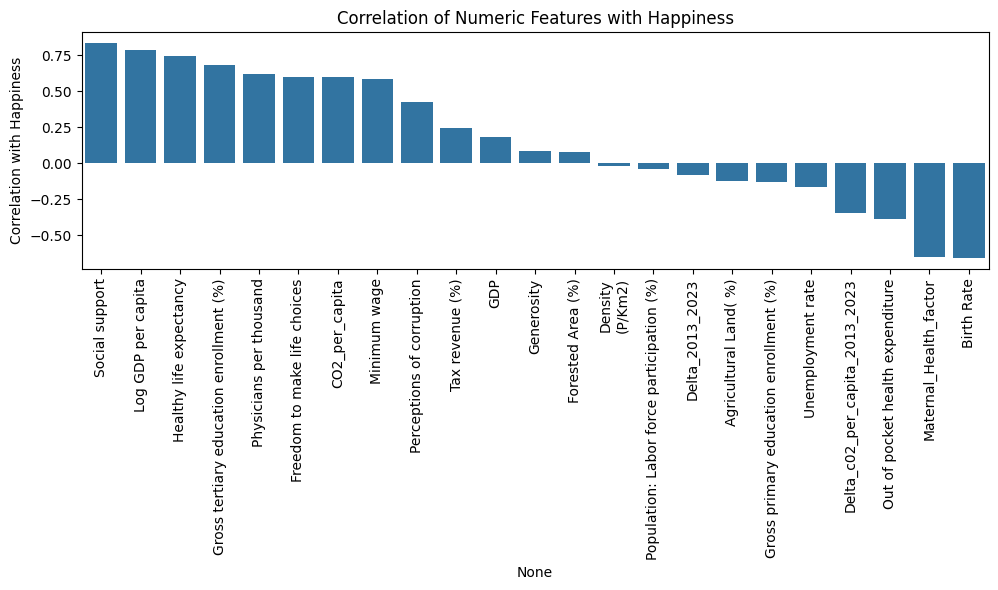

Baseline (Mean Predictor) --> MSE: 1.9184, RMSE: 1.3851, R2: -0.0826
Linear Regression --> MSE: 0.3017, RMSE: 0.5493, R2: 0.8297
Random Forest --> MSE: 0.5256, RMSE: 0.7250, R2: 0.7034
AdaBoost --> MSE: 0.4325, RMSE: 0.6576, R2: 0.7559

Model performance (sorted by MSE):
                       Model       MSE      RMSE        R2
1          Linear Regression  0.301713  0.549284  0.829738
3                   AdaBoost  0.432474  0.657628  0.755948
2              Random Forest  0.525556  0.724952  0.703420
0  Baseline (Mean Predictor)  1.918420  1.385070 -0.082595


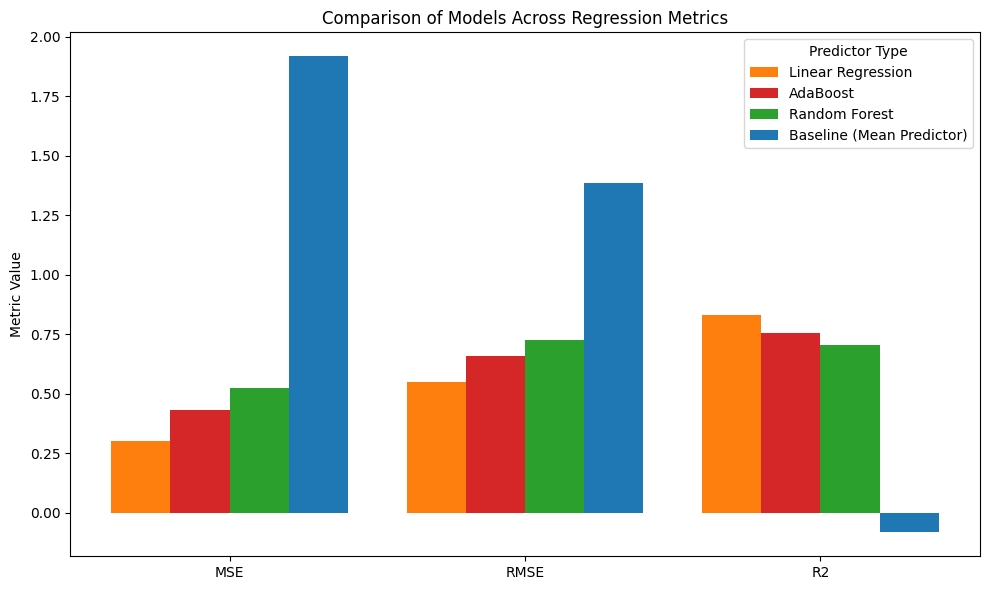

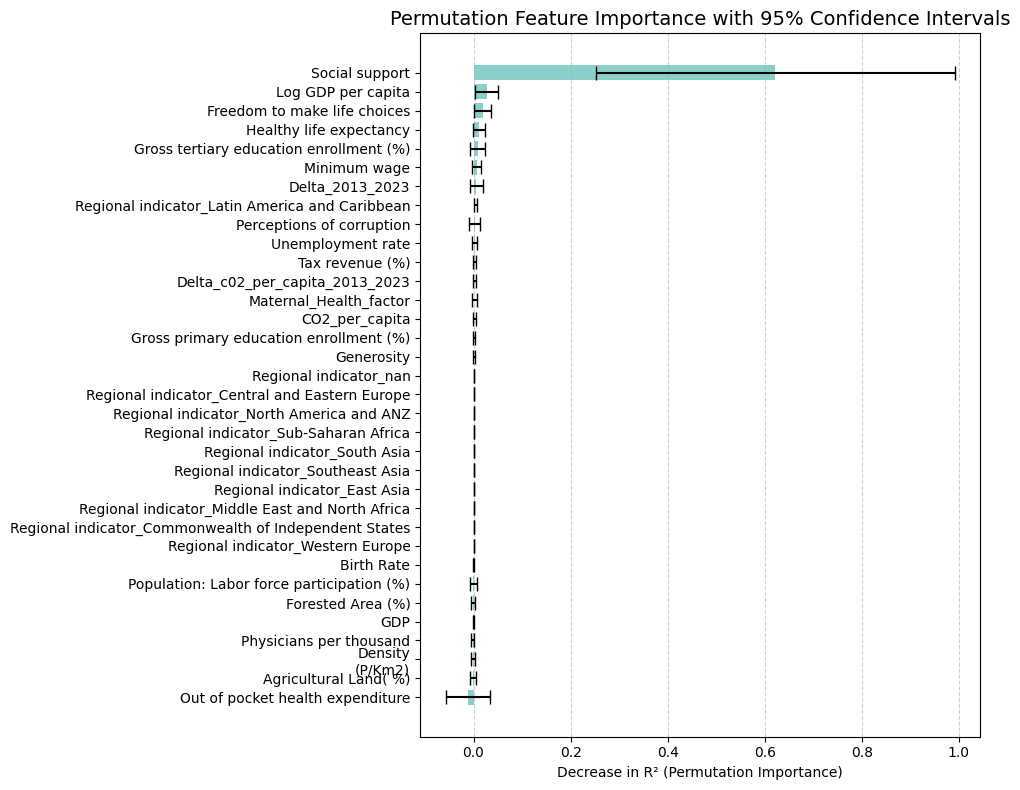

                                              Feature  Importance      Std  CI_lower  CI_upper
                     Out of pocket health expenditure   -0.012262 0.023195 -0.057724  0.033199
                                Agricultural Land( %)   -0.001865 0.003016 -0.007777  0.004048
                                     Density\n(P/Km2)   -0.001472 0.002148 -0.005681  0.002738
                              Physicians per thousand   -0.001470 0.001682 -0.004766  0.001827
                                                  GDP   -0.000889 0.000537 -0.001941  0.000163
                                    Forested Area (%)   -0.000777 0.001825 -0.004354  0.002800
            Population: Labor force participation (%)   -0.000672 0.003617 -0.007761  0.006417
                                           Birth Rate   -0.000671 0.000522 -0.001695  0.000353
                    Regional indicator_Western Europe   -0.000001 0.000003 -0.000007  0.000004
Regional indicator_Commonwealth of Independent Sta

In [19]:
# =============================
# STEP 6 - MODELS
# =============================

# Remapping according to pycountry names
country_fix_map = {
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Democratic Republic of the Congo": "Congo, The Democratic Republic of the",
    "Russia": "Russian Federation",
    "Turkey": "Türkiye",
}
# Apply fixes
world_merged_df['Country'] = world_merged_df['Country'].replace(country_fix_map)
# Create ISO-3 code column
def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None
world_merged_df['iso_alpha'] = world_merged_df['Country'].apply(get_iso3)

# Check if any countries failed
missing_iso = world_merged_df[world_merged_df['iso_alpha'].isna()]['Country'].tolist()
print("Countries without ISO-3 code:", missing_iso)
# Create choropleth using ISO-3 codes
fig = px.choropleth(
    world_merged_df,
    locations='iso_alpha',  # use ISO-3 codes
    color='Happiness',
    hover_name='Country',
    color_continuous_scale='Viridis',
    title='World Happiness Scores (2024)'
)
fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
fig.show()
# Select only numeric columns
numeric_cols = world_merged_df.select_dtypes(include='number').columns
# Compute correlations with Happiness (numeric only)
corr_with_happiness = world_merged_df[numeric_cols].corr()['Happiness'].sort_values(ascending=False)
print(corr_with_happiness)
# Plot correlations minus Happiness itself
corr_with_happiness = corr_with_happiness.drop('Happiness')
plt.figure(figsize=(10,6))
sns.barplot(x=corr_with_happiness.index, y=corr_with_happiness.values)
plt.xticks(rotation=90)
plt.ylabel('Correlation with Happiness')
plt.title('Correlation of Numeric Features with Happiness')
plt.tight_layout()
plt.show()

# Prepare data
# Dummy code 'Regional indicator' (drop_first=True to avoid multicollinearity)
world_merged_df_encoded = world_merged_df.copy()
# Separate target
y = world_merged_df_encoded['Happiness']
# Select numeric + dummy features
numeric_features = world_merged_df.select_dtypes(include='number').columns.tolist()
numeric_features.remove('Happiness')  # Target
dummy_features = [col for col in world_merged_df_encoded.columns if col not in numeric_features + ['Happiness'] + ['Country'] + ['iso_alpha']]
X = world_merged_df_encoded[numeric_features + dummy_features]

# Train-test split and Standardize numeric features (z-score) for Linear Regression only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Fit models
models = {
    "Baseline (Mean Predictor)": None,
    "Linear Regression": LinearRegression(),
    # Random Forest: limit depth and min samples to avoid overfitting
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    # AdaBoost: use small trees as base estimator and adjust learning rate
    "AdaBoost": AdaBoostRegressor(
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )
}
trained_models = models
results = []
for name, model in models.items():
    if name == "Baseline (Mean Predictor)":
        y_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
    elif name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        lr_model = model
    else:  # Tree-based models: use unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "RMSE": rmse, "R2": r2})
    print(f"{name} --> MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
results_df = pd.DataFrame(results).sort_values(by='MSE')
print("\nModel performance (sorted by MSE):")
print(results_df)
# Predictor types (models)
models = results_df['Model'].tolist()
metrics = ['MSE', 'RMSE', 'R2']
values = results_df[metrics].values.T
x = np.arange(len(metrics))
width = 0.2
colors = {'Baseline (Mean Predictor)':'#1f77b4',
          'Linear Regression':'#ff7f0e',
          'Random Forest':'#2ca02c',
          'AdaBoost':'#d62728'}
fig, ax = plt.subplots(figsize=(10,6))
for i, model in enumerate(models):
    ax.bar(x + i*width - width*1.5, values[:, i], width, label=model, color=colors[model])
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Models Across Regression Metrics')
ax.legend(title='Predictor Type')
plt.tight_layout()
plt.show()
# Compute permutation importance using Random Forest
perm = permutation_importance(
    trained_models['Random Forest'],
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='r2'
)
perm_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm.importances_mean,
    "Std": perm.importances_std
})
# Calculate 95% CI
perm_df["CI_lower"] = perm_df["Importance"] - 1.96 * perm_df["Std"]
perm_df["CI_upper"] = perm_df["Importance"] + 1.96 * perm_df["Std"]
perm_df = perm_df.sort_values("Importance", ascending=True)  # ascending for horizontal bars
plt.figure(figsize=(10, 8))
plt.barh(
    perm_df["Feature"],
    perm_df["Importance"],
    xerr=1.96*perm_df["Std"],
    color="#76c7c0",
    alpha=0.85,
    capsize=5
)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlabel("Decrease in R² (Permutation Importance)")
plt.title("Permutation Feature Importance with 95% Confidence Intervals", fontsize=14)
plt.tight_layout()
plt.show()

# Create a table with Feature, Importance, Std, CI_lower, CI_upper
importance_table = perm_df[["Feature", "Importance", "Std", "CI_lower", "CI_upper"]]
print(importance_table.to_string(index=False))

Columns available: ['Country', 'Delta_2013_2023', 'Density\n(P/Km2)', 'Agricultural Land( %)', 'Birth Rate', 'Forested Area (%)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Minimum wage', 'Out of pocket health expenditure', 'Physicians per thousand', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Unemployment rate', 'Happiness', 'Perceptions of corruption', 'Freedom to make life choices', 'Generosity', 'Log GDP per capita', 'Social support', 'Healthy life expectancy', 'Delta_c02_per_capita_2013_2023', 'CO2_per_capita', 'Maternal_Health_factor', 'iso_alpha', 'Region'] 


7.1 Probability → P(Happiness > 6.0) ≈ 0.4000
Interpretation:
- Fraction of countries with Happiness above 6.
- About 40.00% of countries score highly on Happiness.

7.2 Normal Fit → Happiness ≈ Normal(μ=5.496, σ=1.162)


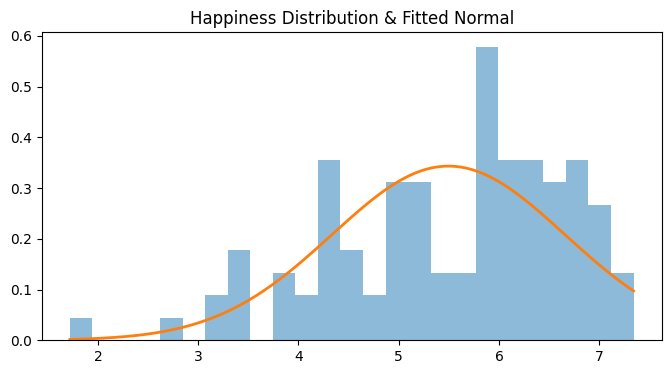

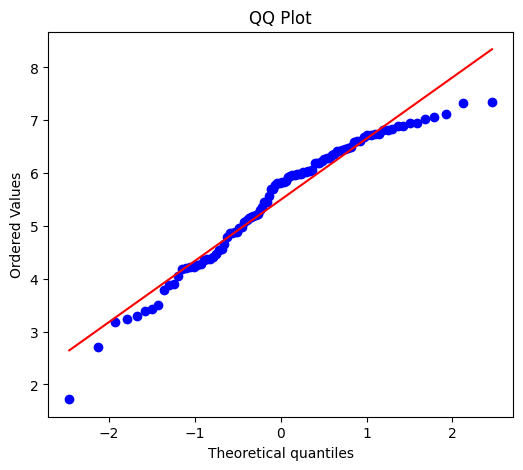

Interpretation:
- The Normal curve overlaid on the histogram shows how well Happiness fits a Gaussian.
- QQ plot alignment = stronger Normality.



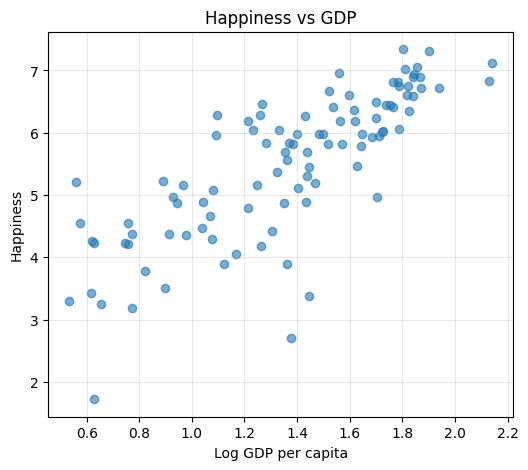

7.3 Correlation → Spearman ρ=0.817, p=3.924e-25
                Pearson r=0.788, p=2.394e-22
Interpretation:
- Positive correlation: richer countries tend to be happier.
- Pearson = linear strength, Spearman = monotonic strength.
- Very small p-values → strong statistical significance.

7.4 Chebyshev → bound=0.250, empirical=0.020
Interpretation:
- Chebyshev gives a universal bound for ANY distribution.
- Empirical proportion < bound → Chebyshev holds easily.



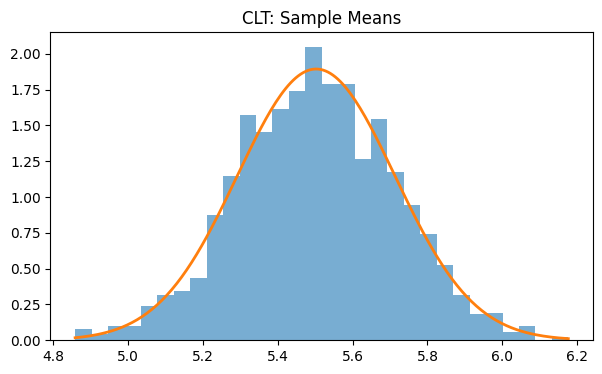

7.5 CLT → mean=5.5022, std=0.2107
Interpretation:
- Distribution of sample means looks Normal (CLT in action).
- Even if raw data isn't perfectly Normal, means converge.

7.6 MGF Estimates:
  M(-0.2) ≈ 0.3428
  M(-0.1) ≈ 0.5812
  M(0.0) ≈ 1.0000
  M(0.1) ≈ 1.7439
  M(0.2) ≈ 3.0793
Interpretation:
- MGF values characterize all moments of the distribution.
- Shows how E[e^{tX}] behaves for positive/negative t.

7.7 Normal MLE → μ=5.4957, σ=1.1617
Exponential MLE → λ=0.1820
Interpretation:
- For a Normal distribution: μ̂ = sample mean, σ̂ = sample std.
- For exponential: λ̂ = 1 / mean.

7.8 95% CI → [5.2640, 5.7273]
Interpretation:
- 95% of intervals constructed this way would contain the true mean.
- CI provides a range estimate for global Happiness.

7.9 T-test → Sub-Saharan Africa vs Latin America and Caribbean: t=-11.160, p=5.333e-13
Interpretation:
- Tests if the two most common regions differ in Happiness.
- Small p-value → significant regional difference.

7.10 Z-test → Z=-0.037, p

In [20]:
# =============================================================================
# STEP 7 — PROBABILITY & STATISTICS ANALYSIS
# =============================================================================

df_stats = world_merged_df.copy()

# -----------------------------------------------------------------------------
# Region Reconstruction
# -----------------------------------------------------------------------------
one_hot_cols = [c for c in df_stats.columns if c.startswith('Regional indicator_')]

def decode_region(row):
    for col in one_hot_cols:
        if row[col] == 1:
            return col.replace('Regional indicator_', '')
    return "Unknown"

df_stats['Region'] = df_stats.apply(decode_region, axis=1)
df_stats = df_stats.drop(columns=one_hot_cols)

print("Columns available:", df_stats.columns.tolist(), "\n")

X = df_stats['Happiness'].dropna()


# =============================================================================
# 7.1 BASIC PROBABILITY
# =============================================================================
threshold = 6.0
prob_happy_gt = np.mean(X > threshold)
print(f"\n7.1 Probability → P(Happiness > {threshold}) ≈ {prob_happy_gt:.4f}")

# --- Interpretation ---
print("Interpretation:")
print(f"- Fraction of countries with Happiness above 6.")
print(f"- About {prob_happy_gt*100:.2f}% of countries score highly on Happiness.\n")


# =============================================================================
# 7.2 NORMAL FIT + QQ PLOT
# =============================================================================
h = X.values
mu_h, sigma_h = stats.norm.fit(h)
print(f"7.2 Normal Fit → Happiness ≈ Normal(μ={mu_h:.3f}, σ={sigma_h:.3f})")

plt.figure(figsize=(8,4))
plt.hist(h, bins=25, density=True, alpha=0.5)
xx = np.linspace(h.min(), h.max(), 200)
plt.plot(xx, stats.norm.pdf(xx, mu_h, sigma_h), lw=2)
plt.title('Happiness Distribution & Fitted Normal')
plt.show()

plt.figure(figsize=(6,5))
stats.probplot(h, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

# --- Interpretation ---
print("Interpretation:")
print("- The Normal curve overlaid on the histogram shows how well Happiness fits a Gaussian.")
print("- QQ plot alignment = stronger Normality.\n")


# =============================================================================
# 7.3 GDP–HAPPINESS CORRELATION
# =============================================================================
df_tmp = df_stats[['Log GDP per capita','Happiness']].dropna()

plt.figure(figsize=(6,5))
plt.scatter(df_tmp['Log GDP per capita'], df_tmp['Happiness'], alpha=0.6)
plt.xlabel('Log GDP per capita')
plt.ylabel('Happiness')
plt.title('Happiness vs GDP')
plt.grid(alpha=0.3)
plt.show()

rho, p_rho = stats.spearmanr(df_tmp['Log GDP per capita'], df_tmp['Happiness'])
pearson_r, p_pearson = stats.pearsonr(df_tmp['Log GDP per capita'], df_tmp['Happiness'])

print(f"7.3 Correlation → Spearman ρ={rho:.3f}, p={p_rho:.3e}")
print(f"                Pearson r={pearson_r:.3f}, p={p_pearson:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Positive correlation: richer countries tend to be happier.")
print("- Pearson = linear strength, Spearman = monotonic strength.")
print("- Very small p-values → strong statistical significance.\n")


# =============================================================================
# 7.4 CHEBYSHEV INEQUALITY
# =============================================================================
mu_x = X.mean()
sigma_x = X.std(ddof=0)
k = 2
cheb_bound = 1.0 / (k**2)
empirical = np.mean(np.abs(X - mu_x) >= k * sigma_x)

print(f"7.4 Chebyshev → bound={cheb_bound:.3f}, empirical={empirical:.3f}")

# --- Interpretation ---
print("Interpretation:")
print("- Chebyshev gives a universal bound for ANY distribution.")
print("- Empirical proportion < bound → Chebyshev holds easily.\n")


# =============================================================================
# 7.5 CENTRAL LIMIT THEOREM (BOOTSTRAP SAMPLE MEANS)
# =============================================================================
sample_size = 30
n_experiments = 2000

means = np.array([
    X.sample(sample_size, replace=True, random_state=i).mean()
    for i in range(n_experiments)
])

plt.figure(figsize=(7,4))
plt.hist(means, bins=30, density=True, alpha=0.6)
xx = np.linspace(means.min(), means.max(), 200)
plt.plot(xx, stats.norm.pdf(xx, means.mean(), means.std()), lw=2)
plt.title('CLT: Sample Means')
plt.show()

print(f"7.5 CLT → mean={means.mean():.4f}, std={means.std():.4f}")

# --- Interpretation ---
print("Interpretation:")
print("- Distribution of sample means looks Normal (CLT in action).")
print("- Even if raw data isn't perfectly Normal, means converge.\n")


# =============================================================================
# 7.6 EMPIRICAL MGF
# =============================================================================
t_values = [-0.2, -0.1, 0.0, 0.1, 0.2]
mgf_values = {t: np.mean(np.exp(t * X)) for t in t_values}

print("7.6 MGF Estimates:")
for t, v in mgf_values.items():
    print(f"  M({t}) ≈ {v:.4f}")

# --- Interpretation ---
print("Interpretation:")
print("- MGF values characterize all moments of the distribution.")
print("- Shows how E[e^{tX}] behaves for positive/negative t.\n")


# =============================================================================
# 7.7 MAXIMUM LIKELIHOOD ESTIMATION
# =============================================================================
mu_mle = X.mean()
sigma_mle = X.std(ddof=0)

print(f"7.7 Normal MLE → μ={mu_mle:.4f}, σ={sigma_mle:.4f}")

if (X > 0).all():
    print(f"Exponential MLE → λ={1/X.mean():.4f}")
else:
    print("Exponential MLE → skipped (non-positive values)")

# --- Interpretation ---
print("Interpretation:")
print("- For a Normal distribution: μ̂ = sample mean, σ̂ = sample std.")
if (X > 0).all():
    print("- For exponential: λ̂ = 1 / mean.")
print()


# =============================================================================
# 7.8 95% CONFIDENCE INTERVAL
# =============================================================================
mean_h = X.mean()
sem_h = stats.sem(X)
ci_low, ci_high = stats.t.interval(0.95, df=len(X)-1, loc=mean_h, scale=sem_h)

print(f"7.8 95% CI → [{ci_low:.4f}, {ci_high:.4f}]")

# --- Interpretation ---
print("Interpretation:")
print("- 95% of intervals constructed this way would contain the true mean.")
print("- CI provides a range estimate for global Happiness.\n")


# =============================================================================
# 7.9 REGION-BASED T-TEST (TOP 2 REGIONS)
# =============================================================================
region_counts = df_stats['Region'].value_counts()
top2 = region_counts.index[:2]

g1 = df_stats.loc[df_stats['Region'] == top2[0], 'Happiness'].dropna()
g2 = df_stats.loc[df_stats['Region'] == top2[1], 'Happiness'].dropna()

t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
print(f"7.9 T-test → {top2[0]} vs {top2[1]}: t={t_stat:.3f}, p={p_val:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests if the two most common regions differ in Happiness.")
print("- Small p-value → significant regional difference.\n")


# =============================================================================
# 7.10 Z-TEST AGAINST 5.5
# =============================================================================
pop_ref = 5.5
z_stat = (X.mean() - pop_ref) / (X.std(ddof=1) / np.sqrt(len(X)))
p_z = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"7.10 Z-test → Z={z_stat:.3f}, p={p_z:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests whether world mean Happiness = 5.5.")
print("- Small p → mean differs significantly from 5.5.\n")


# =============================================================================
# 7.11 CHI-SQUARE TEST (REGION × CORRUPTION)
# =============================================================================
tmp = df_stats[['Region', 'Perceptions of corruption']].dropna()
tmp['HighCorruption'] = (tmp['Perceptions of corruption'] >
                         tmp['Perceptions of corruption'].median()).astype(int)

ct = pd.crosstab(tmp['Region'], tmp['HighCorruption'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)

print(f"7.11 Chi-square → chi2={chi2:.3f}, p={p_chi:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests independence between Region and Corruption.")
print("- Significant p → corruption varies meaningfully by region.\n")


# =============================================================================
# 7.12 BONFERRONI MULTIPLE TESTING
# =============================================================================
features = [
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom to make life choices',
    'Generosity'
]

pvals, names = [], []

for feat in features:
    df_tmp = df_stats[[feat, 'Happiness']].dropna()
    r, p = stats.pearsonr(df_tmp[feat], df_tmp['Happiness'])
    pvals.append(p)
    names.append(feat)

corrected = np.minimum(np.array(pvals) * len(pvals), 1.0)

print("7.12 Bonferroni Correction:")
for f, p_orig, p_corr in zip(names, pvals, corrected):
    print(f"  {f}: p={p_orig:.3e}, corrected={p_corr:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Bonferroni guards against false positives from multiple tests.")
print("- Features with small corrected p remain truly significant.\n")

print("STEP 7 complete.\n")